In [1]:
import os
import sys
import random
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import json
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from scipy.stats import spearmanr, pearsonr
import argparse
from scipy.stats import norm
import numpy as np
from collections import Counter
import seaborn as sns 
import matplotlib.pyplot as plt
# import matplolib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init

class ESMBA(nn.Module):
    def __init__(self, base_model, dropout=0.3):
        """
        Args:
            base_model: A pretrained model that returns a structure with a
                        'last_hidden_state' attribute.
            dropout (float): Dropout rate applied after pooling.
        """
        super(ESMBA, self).__init__()
        self.base_model = base_model
        # self.config = base_model.config  # assumes base_model has a config with hidden_size
        self.dropout = nn.Dropout(dropout)
        # import torch.nn.init as init
        # init.xavier_uniform_(self.regression_head.weight, gain=0.01)
        self.regression_head = nn.Linear(960, 1)

        init.xavier_uniform_(self.regression_head.weight, gain=0.01)
        nn.init.uniform_(self.regression_head.bias, a=0.0, b=1.0)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model.forward(input_ids)
        hidden_states = outputs.hidden_states[-1].to(torch.float32)
        # print("Hidden states shape:", hidden_states.shape,
        #     "Mean:", hidden_states.mean().item(),
        #     "Std:", hidden_states.std().item())

        mask = attention_mask.unsqueeze(-1).float()
        masked_hidden_states = hidden_states * mask
        # print("Masked mean:", masked_hidden_states.mean().item(),
        #     "std:", masked_hidden_states.std().item())

        sum_embeddings = masked_hidden_states.sum(dim=1)
        sum_mask = mask.sum(dim=1)
        pooled_output = sum_embeddings / (sum_mask + 1e-8)
        # print("Pooled shape:", pooled_output.shape,
        #     "Mean:", pooled_output.mean().item(),
        #     "Std:", pooled_output.std().item())

        pooled_output = self.dropout(pooled_output)
        regression_output = self.regression_head(pooled_output).squeeze(-1)
        # print("Regression out shape:", regression_output.shape,
        #     "Mean:", regression_output.mean().item(),
        #     "Std:", regression_output.std().item())
        
        # final_pred = 5.0 * torch.sigmoid(self.regression_head(pooled_output))
        final_pred = self.regression_head(pooled_output)

        return final_pred
        
def load_model(model_path, device='cpu'):
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    config = checkpoint['config']
    
    # 1. Load base ESMC model
    base_model = ESMC.from_pretrained("esmc_300m").to(device)
    
    # 3. Wrap with ESMCMasked using saved config
    model = ESMBA(
        base_model,
    ).to(device)
    
    # 4. Load trained weights
    state_dict = checkpoint['model_state_dict']

    # Remove keys corresponding to the old mask head
    state_dict = {k: v for k, v in state_dict.items() if not k.startswith('mask_head')}
    
    model.load_state_dict(state_dict, strict=False)
    
    return model

In [3]:

# if not torch.cuda.is_available():
#     print("CUDA is not available. Exiting.")
#     sys.exit(1)

device = torch.device("cpu")
print(f"Using device: {device}", flush=True)

full_pretraining = False  # Simplified boolean conversion
name_of_model = "RUN2"
encoding = 'HLA'
file_path = '/global/scratch/users/sergiomar10/models/esm_c/masking/HLA-0201_epitope_only/False-Full_pretraining_2000_seq_AUG_3.pt'
file_path = '/global/scratch/users/sergiomar10/models/esm_c/masking/ALLHLAs_epitope_only/True-Full_pretraining_30000_seq_AUG_3_ALL_HLAS.pt'

model_path = '/global/scratch/users/sergiomar10/models/ESMCBA_02032025/A0101/training_ESMCBA_epitope_0.5_30_ESMMASK_epitope_FT_25_0.001_1e-05_AUG_6_HLAA0101_2_0.0001_1e-05__1_A0101_MSE__final.pth'
    

model = load_model(
    file_path,  # Must match training setting!
    device=device
)

base_model = model.base_model

Using device: cpu


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
base_model

ESMC(
  (embed): Embedding(64, 960)
  (transformer): TransformerStack(
    (blocks): ModuleList(
      (0-29): 30 x UnifiedTransformerBlock(
        (attn): MultiHeadAttention(
          (layernorm_qkv): Sequential(
            (0): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=960, out_features=2880, bias=False)
          )
          (out_proj): Linear(in_features=960, out_features=960, bias=False)
          (q_ln): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
          (k_ln): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
          (rotary): RotaryEmbedding()
        )
        (ffn): Sequential(
          (0): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=960, out_features=5120, bias=False)
          (2): SwiGLU()
          (3): Linear(in_features=2560, out_features=960, bias=False)
        )
      )
    )
    (norm): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
  )
  (sequ

In [5]:
size_of_train = 0.5
blocks_unfrozen = 25

#########################################################
# 4. Define a mapping for the 20 standard amino acids
#########################################################
amino_acids = "ARNDCEQGHILKMFPSTWYV"

# Map each amino acid to its tokenizer-assigned ID
aa_to_idx = {
    aa: base_model.tokenizer(text=aa).input_ids[1]  # index=1 to skip <cls> or start token
    for aa in amino_acids
}

# Reverse mapping: token_id → amino acid
idx_to_aa = {idx: aa for aa, idx in aa_to_idx.items()}

# print(f"aa_to_idx: {aa_to_idx}", flush=True)
# print(f"idx_to_aa: {idx_to_aa}", flush=True)

####################################################
# 5. Set up training: optimizer and loss function
####################################################

# Gather last 10 blocks into one list
last_10_block_params = []
for block_idx in range(20, 30):
    last_10_block_params.extend(
        list(model.base_model.transformer.blocks[block_idx].parameters())
    )

norm_params = list(model.base_model.transformer.norm.parameters())
# (optional) You can decide whether to keep final norm in the same LR group or not
last_10_block_params.extend(norm_params)


optimizer = optim.Adam(
    [
        {"params": last_10_block_params, "lr": 0.0001},
        {"params": model.regression_head.parameters(), "lr": 1e-6},
    ],
    weight_decay=1e-5
)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

# for i, group in enumerate(optimizer.param_groups):
#     print(f"Group {i} LR: {group['lr']}")
#     param_names = [n for n, p in model.named_parameters() if p in group['params']]
#     print(f" --> {param_names}")


In [6]:
encoding = 'epitope'

################################################
# 6. Define a simple FASTA parser
################################################
def parse_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as f:
        header = None
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append((header, seq))
                    seq = ""
                header = line[1:]
            else:
                seq += line
        # Append the last sequence if present
        if seq:
            sequences.append((header, seq))
    return sequences

train_fasta = f"/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLA{'A1101'}_final.csv"

epitope_data = pd.read_csv(train_fasta, header = None)
epitope_data.columns = ['sequence', 'ref_ID', 'submissionID', 'Epitope_ID','protein_origin', 'ID_SOURCE', "SOURCE_ORGANISM", "IC50_nM", "DESCRIPTION_BINDING", "Year_submission"]
HLA_0201 = "MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDMGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQRTDAPKTHMTHHAVSDHEATLRCWALSFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGQEQRYTCHVQHEGLPKPLTLRWEP"

epitope_data['IC50_nM'] = epitope_data['IC50_nM'].astype(str)
epitope_data['IC50_nM'] = epitope_data['IC50_nM'].str.replace('\\N', '0', regex=False)
epitope_data['IC50_nM'] = epitope_data['IC50_nM'].astype('float')
epitope_data['IC50_nM'] = epitope_data['IC50_nM'] + 1
epitope_data['IC50_nM'] = epitope_data['IC50_nM'].apply(np.log10)

epitope_data['Year_submission'] = epitope_data['Year_submission'].astype(str)
epitope_data['Year_submission'] = epitope_data['Year_submission'].str.replace('\\N', '0', regex=False)
epitope_data['Year_submission'] = epitope_data['Year_submission'].astype(int)

epitope_data = epitope_data[["IC50_nM","sequence","Year_submission"]]

epitope_data = epitope_data.values

filtered_data = []

for header, sequence, year_submission in epitope_data:
    if '+' in sequence:
        continue
    if '(' in sequence:
        continue
    if 'X' in sequence:
        continue
    if 'epitope' not in encoding:   
        sequence = HLA_0201 + sequence
        
    filtered_data.append((header, sequence, year_submission))

print(f"Filtered {len(filtered_data)} sequences for training.", flush=True)

aggregated = pd.DataFrame(filtered_data, columns = ['label','sequence','testing'])
# aggregated = aggregated.iloc[:100]

def split_data(aggregated, size_of_train=1.0):
    """
    Split data into Train (bin-sampled), Validation (10% of that train),
    and Test (20% of total). For final 'external' test, you can still use
    aggregated['Year_submission'] > 2020 if desired.
    """
    # 1) Split out the portion to treat as test_data (20%)
    #    from the portion <= 2020
    training_data = aggregated[aggregated['testing'] <= 2020]

    # 2) Bin-sample 'train_data' according to your normal approach
    print(f'Threshold used for generating the training data {size_of_train}', flush=True)
    bin_edges = [0, 1, 2, 3, 4, 5, 6, 7]
    bin_centers_normal = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    pmf = norm.pdf(bin_centers_normal, loc=3, scale=1.0)
    pmf /= pmf.sum()
    total_samples = int(size_of_train * len(training_data))
    bin_samples_normal = np.round(pmf * total_samples).astype(int)

    sampled_sequences, sampled_labels = [], []
    for i in range(len(bin_centers_normal)):
        bin_min = bin_edges[i]
        bin_max = bin_edges[i + 1]
        df_bin = training_data[(training_data["label"] > bin_min) & (training_data["label"] <= bin_max)]
        n_samples = min(bin_samples_normal[i], len(df_bin))
        if n_samples > 0:
            sample = df_bin.sample(n=n_samples)
            sampled_sequences.extend(sample["sequence"].tolist())
            sampled_labels.extend(sample["label"].tolist())

    # Construct the final "train_data" from the bin-sampled sequences
    final_train = pd.DataFrame({"sequence": sampled_sequences, "label": sampled_labels})

    # Print threshold info for generating the training data
    # print(f'Threshold used for generating the training data: {size_of_train}', flush=True)

    # # Define the bin edges and centers (these remain the same)
    # bin_edges = [0, 1, 2, 3, 4, 5, 6, 7]
    # bin_centers = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]

    # # Create a uniform PMF across the bins: each bin gets the same weight.
    # pmf_uniform = np.ones(len(bin_centers)) / len(bin_centers)

    # # Calculate the total number of samples to draw from the training data.
    # total_samples = int(size_of_train * len(training_data))

    # # Determine how many samples to draw from each bin.
    # bin_samples_uniform = np.round(pmf_uniform * total_samples).astype(int)

    # # Prepare lists to store the sampled sequences and labels.
    # sampled_sequences, sampled_labels = [], []

    # # Loop over each bin and sample uniformly.
    # for i in range(len(bin_centers)):
    #     bin_min = bin_edges[i]
    #     bin_max = bin_edges[i + 1]
        
    #     # Select the data in the current bin.
    #     df_bin = training_data[(training_data["label"] > bin_min) & (training_data["label"] <= bin_max)]
        
    #     # Determine the number of samples to draw (cannot exceed available samples).
    #     n_samples = min(bin_samples_uniform[i], len(df_bin))
        
    #     # Sample if there are enough points.
    #     if n_samples > 0:
    #         sample = df_bin.sample(n=n_samples, random_state=42)
    #         sampled_sequences.extend(sample["sequence"].tolist())
    #         sampled_labels.extend(sample["label"].tolist())

    # # Construct the final training DataFrame from the sampled data.
    # final_train = pd.DataFrame({"sequence": sampled_sequences, "label": sampled_labels})

    # 3) Now split *final_train* into 90% train, 10% validation
    #    This ensures we keep 10% (of the final training set) for validation
    train_data_final, val_data_final = train_test_split(
        final_train, 
        test_size=0.1,
        shuffle=True
    )

    # Optional histogram to check distribution
    num_bins = 7
    counts, bin_edges_ = np.histogram(train_data_final['label'], bins=num_bins)
    max_count = max(counts) if len(counts) > 0 else 1
    scale_factor = 50 / max_count

    print(f"\nTrain Histogram with {num_bins} Bins (after bin-sampling & removing val set):")
    for i in range(len(bin_edges_) - 1):
        bin_range = f"[{bin_edges_[i]:.2f}, {bin_edges_[i+1]:.2f})"
        bar = "#" * int(counts[i] * scale_factor)
        print(f"{bin_range}: {bar} ({counts[i]})")

    print('We are generating the 2021 Testing set', flush = True)

    test_data = aggregated[aggregated['testing'] > 2020]

    if len(test_data['label']) < 10:
        print('Not enough samples past the 2021 treshold', flush = True)
        output_table = aggregated[~aggregated["sequence"].isin(sampled_sequences)]
        test_data = pd.concat([output_table, test_data])

    test_data = test_data[['sequence','label']]

    return train_data_final, val_data_final, test_data

from torch.utils.data import Dataset, DataLoader
import torch

# Your dataset now computes the protein object (and encoding) during __getitem__
class EpitopeDataset(Dataset):
    def __init__(self, sequences, labels, base_model=base_model, precompute=False):
        self.labels = labels
        if precompute:
            # Precompute the protein objects (and their encodings) once and store them
            self.data = []
            for seq in sequences:
                protein_obj = ESMProtein(sequence=seq)
                # Precompute the encoding (if your base_model is frozen or you want to save time)
                protein_tensor = base_model.encode(protein_obj)
                self.data.append((protein_obj, protein_tensor))
        else:
            # Otherwise, store the raw sequences so that they are computed on the fly in __getitem__
            self.sequences = sequences

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if hasattr(self, "data"):
            # If precomputed, return the stored protein object and its encoding.
            protein_obj, protein_tensor = self.data[idx]
            return protein_obj, protein_tensor, torch.tensor(label, dtype=torch.float)
        else:
            # Otherwise, compute the protein object (and encoding) on the fly.
            seq = self.sequences[idx]
            protein_obj = ESMProtein(sequence=seq)
            protein_tensor = base_model.encode(protein_obj)
            return seq, protein_tensor, torch.tensor(label, dtype=torch.float)

# A collate function that gathers protein objects into a list (they may have varying shapes)
def collate_fn(batch):
    # Each element of batch is (sequence, protein_tensor, label)
    sequences, protein_tensors, labels = zip(*batch)
    # Leave sequences as a list (they are custom objects)
    # If protein_tensors have the same shape you can stack them, otherwise leave as list:
    try:
        protein_tensors = torch.stack(protein_tensors)
    except Exception:
        protein_tensors = list(protein_tensors)
    labels = torch.stack(labels)
    return list(sequences), protein_tensors, labels

# Data preparation function
def prepare_dataloaders(dataframe, batch_size=10, size_of_train=1):
    """
    Split the dataframe into train, validation, and test sets,
    then return corresponding DataLoader objects.
    """
    print(f"\n----------------------------------------\nPreparing data...", flush=True)
    train_data, val_data, test_data = split_data(dataframe, size_of_train=size_of_train)
    
    print(f"Training samples: {len(train_data)}, "
          f"Validation samples: {len(val_data)}, "
          f"Test samples: {len(test_data)}\n----------------------------------------\n", flush=True)

    train_dataset = EpitopeDataset(
        sequences=train_data["sequence"].values,
        labels=train_data["label"].values,
    )
    val_dataset = EpitopeDataset(
        sequences=val_data["sequence"].values,
        labels=val_data["label"].values,
    )
    test_dataset = EpitopeDataset(
        sequences=test_data["sequence"].values,
        labels=test_data["label"].values,
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader, train_data, val_data, test_data

# Prepare the DataLoaders (no tokenization in the DataLoader)
train_loader, val_loader, test_loader, train_data, val_data, test_data = prepare_dataloaders(
    dataframe=aggregated,
    batch_size=10,
    size_of_train=size_of_train
)

criterion = nn.MSELoss()

Filtered 5833 sequences for training.

----------------------------------------
Preparing data...
Threshold used for generating the training data 0.5

Train Histogram with 7 Bins (after bin-sampling & removing val set):
[0.15, 1.04): ### (61)
[1.04, 1.94): ################### (304)
[1.94, 2.83): ################################################## (800)
[2.83, 3.73): ############################################### (765)
[3.73, 4.62): ############################# (476)
[4.62, 5.52): ###### (101)
[5.52, 6.42):  (6)
We are generating the 2021 Testing set
Training samples: 2513, Validation samples: 280, Test samples: 75
----------------------------------------



In [7]:
test_data = pd.read_csv('/global/scratch/users/sergiomar10/py_files/PEPTIDES_COSTELLO.csv')

In [8]:
test_dataset = EpitopeDataset(
    sequences=test_data["sequence"].values,
    labels=test_data["label"].values,
)

test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=collate_fn)

In [9]:

# -------------------------
# Test Set Evaluation
# -------------------------
sequences_list = []
predictions_list = []
measured_list = []

model.eval()
with torch.no_grad():
    for batch_num, (sequences, protein_tensors, targets) in enumerate(test_loader, start=1):
        targets = targets.to(device)
        encoded_seq = base_model.tokenizer(sequences, return_tensors='pt', padding=True).input_ids.to(device)
        attention_mask = base_model.tokenizer(sequences, return_tensors='pt', padding=True).attention_mask.to(device)

        outputs = model(input_ids=encoded_seq, attention_mask=attention_mask)

        # Process each sample in the batch:
        for i, sequence in enumerate(sequences):
            # If the protein object has an attribute (e.g., `sequence.sequence`), use it; otherwise, use the raw value.
            if hasattr(sequence, "sequence"):
                sequences_list.append(sequence.sequence)
            else:
                sequences_list.append(sequence)
            predictions_list.append(outputs[i].cpu().numpy().item())
            measured_list.append(targets[i].cpu().numpy().item())

print("Done with predictions from test_loader.", flush=True)

predictions_finetuned_esm = pd.DataFrame({
    'sequence': sequences_list,
    'prediction': predictions_list,
    'measured': measured_list
})

KeyboardInterrupt: 

In [10]:
predictions_finetuned_esm = pd.DataFrame({
    'sequence': sequences_list,
    'prediction': predictions_list,
    'measured': measured_list
})

In [11]:
predictions_finetuned_esm

,sequence,prediction,measured
0,VLSRRPEL,-0.996233,0.0
1,LSRRPELL,-0.964865,0.0
2,SRRPELLP,-0.740143,0.0
3,RRPELLPM,-0.800755,0.0
4,RPELLPML,-0.518434,0.0
...,...,...,...
39995,YPEVIKLME,-0.830131,0.0
39996,PEVIKLMES,-0.855176,0.0
39997,EVIKLMESI,-0.710305,0.0
39998,VIKLMESIT,-0.897624,0.0


In [15]:
predictions_finetuned_esm.to_csv('FUSION_FINETUNED_PREDICTIOSN.csv')

In [18]:
mhcflurry = pd.read_csv('../data/MHCFlurry_evals/HLA-A0101_FUSIONS_mhc_flurry.csv')

In [19]:
predictions = pd.merge(predictions_finetuned_esm, mhcflurry, left_on='sequence', right_on='peptide', how='left')
predictions

,sequence,prediction,measured,allele,peptide,mhcflurry_affinity,mhcflurry_affinity_percentile,mhcflurry_processing_score,mhcflurry_presentation_score,mhcflurry_presentation_percentile
0,VLSRRPEL,-0.996233,0.0,HLA-A0101,VLSRRPEL,31348.926160,36.039500,0.177603,0.006035,37.359049
1,VLSRRPEL,-0.996233,0.0,HLA-A0101,VLSRRPEL,31348.926160,36.039500,0.177603,0.006035,37.359049
2,VLSRRPEL,-0.996233,0.0,HLA-A0101,VLSRRPEL,31348.926160,36.039500,0.177603,0.006035,37.359049
3,VLSRRPEL,-0.996233,0.0,HLA-A0101,VLSRRPEL,31348.926160,36.039500,0.177603,0.006035,37.359049
4,LSRRPELL,-0.964865,0.0,HLA-A0101,LSRRPELL,28018.039184,18.389500,0.066737,0.004554,62.744674
...,...,...,...,...,...,...,...,...,...,...
64967,YPEVIKLME,-0.830131,0.0,HLA-A0101,YPEVIKLME,25144.891564,12.170375,0.026894,0.004394,62.744674
64968,PEVIKLMES,-0.855176,0.0,HLA-A0101,PEVIKLMES,32088.585778,47.853875,0.018668,0.003371,99.286603
64969,EVIKLMESI,-0.710305,0.0,HLA-A0101,EVIKLMESI,25934.148207,13.542625,0.750962,0.052588,4.887418
64970,VIKLMESIT,-0.897624,0.0,HLA-A0101,VIKLMESIT,31924.160409,43.368875,0.002592,0.003201,99.286603


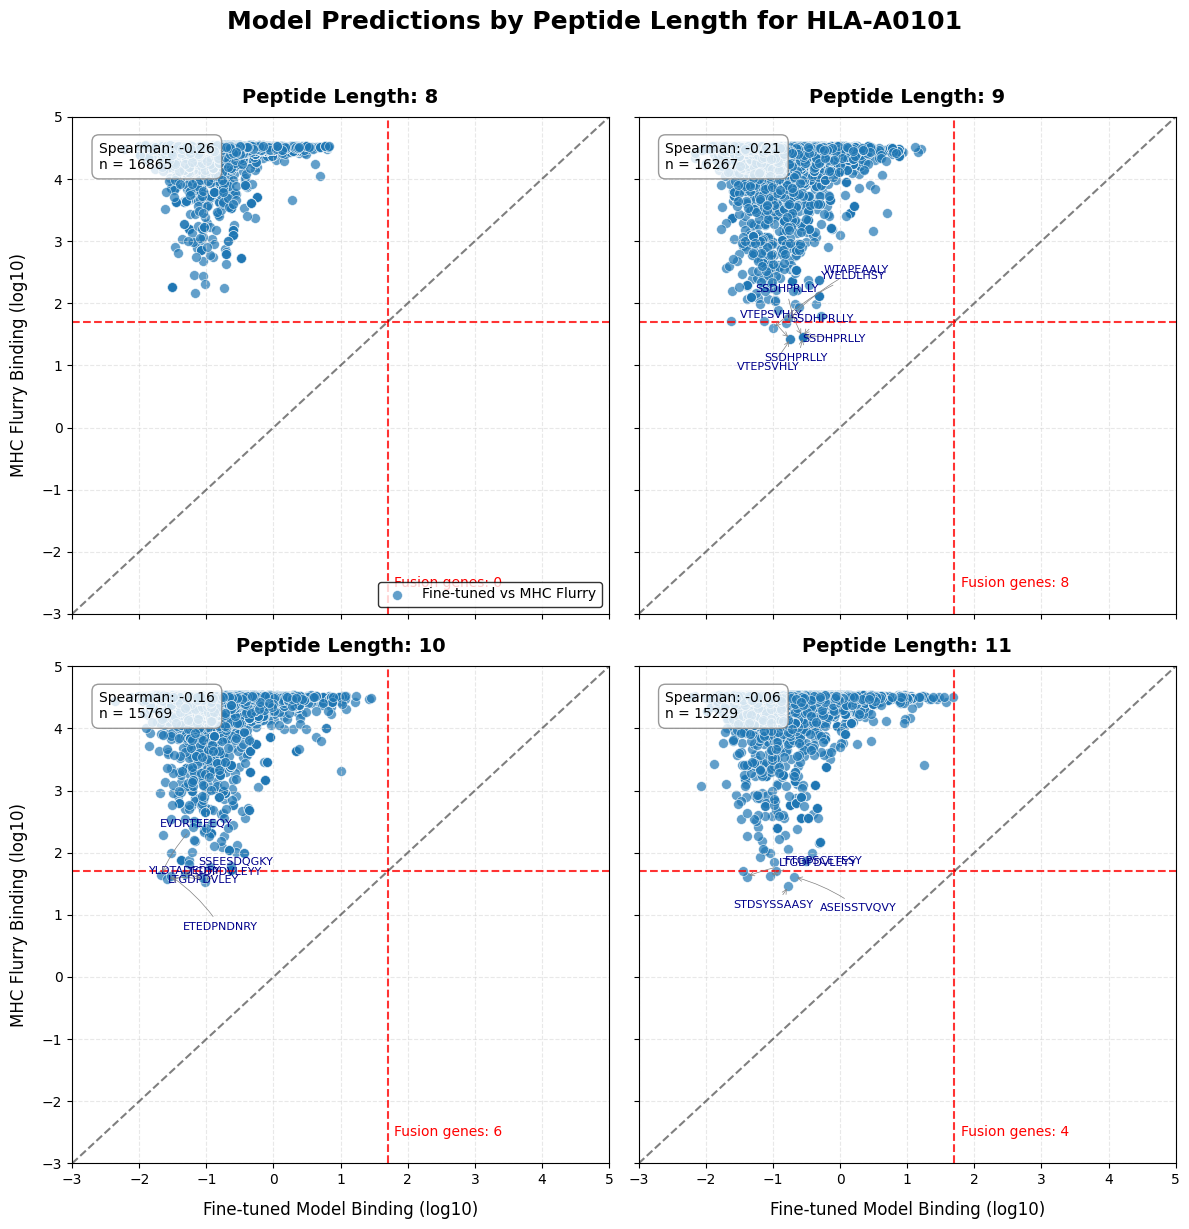

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming predictions DataFrame is defined elsewhere
HLA = 'HLA-A0101'

# Compute the log-transformed affinity for MHC Flurry
predictions['mhc_log'] = predictions['mhcflurry_affinity'].apply(np.log10)
predictions = predictions[predictions['mhc_log'].notna()]

# Create a new column for peptide length
predictions['length'] = predictions['sequence'].str.len()

# Prepare a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Define colors and styles
scatter_color = '#1f77b4'
line_color = '#ff7f0e'
grid_color = '#d3d3d3'
ref_line_color = '#ff0000'

# Threshold for fusion genes
log50 = np.log10(50)

# Loop over the four peptide lengths
for idx, L in enumerate([8, 9, 10, 11]):
    ax = axes[idx]
    preds_length = predictions[predictions['length'] == L]
    if preds_length.empty:
        ax.text(0.5, 0.5, f"No data for length {L}", ha='center', va='center', 
                fontsize=12, color='gray')
        ax.set_title(f"Length {L}", fontsize=14, pad=10)
        continue

    # Scatter plot
    ax.scatter(preds_length['prediction'], preds_length['mhc_log'], 
               c=scatter_color, alpha=0.7, s=50, edgecolors='w', linewidth=0.5, 
               label='Fine-tuned vs MHC Flurry')

    # Set limits and ticks
    ax.set_xlim([-3, 5])
    ax.set_ylim([-3, 5])
    ax.set_xticks(np.arange(-3, 6, 1))
    ax.set_yticks(np.arange(-3, 6, 1))

    # Add red lines at np.log10(50)
    ax.axhline(y=log50, color=ref_line_color, linestyle='--', linewidth=1.5, alpha=0.8)
    ax.axvline(x=log50, color=ref_line_color, linestyle='--', linewidth=1.5, alpha=0.8)

    # Add diagonal reference line
    ax.plot([-3, 5], [-3, 5], 'k--', alpha=0.5, lw=1.5)

    # Compute Spearman correlation
    sp_mhc, _ = spearmanr(preds_length['prediction'], preds_length['mhc_log'])

    # Annotate with Spearman correlation and sample size
    annotation = (f"Spearman: {sp_mhc:.2f}\n"
                  f"n = {len(preds_length)}")
    ax.text(0.05, 0.95, annotation, transform=ax.transAxes, 
            fontsize=10, va='top', ha='left', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

    # Count fusion genes (peptides below log50 in both dimensions)
    fusion_count = len(preds_length[(preds_length['prediction'] < log50) & 
                                    (preds_length['mhc_log'] < log50)])
    ax.text(log50 + 0.1, -2.5, f"Fusion genes: {fusion_count}", 
            fontsize=10, color=ref_line_color, ha='left', va='center')

    # Annotate bottom 10 peptides below log50 with random spread
    below_threshold = preds_length[(preds_length['prediction'] < log50) & 
                                   (preds_length['mhc_log'] < log50)]
    if not below_threshold.empty:
        bottom_10 = below_threshold.nsmallest(10, 'mhc_log')
        for _, row in bottom_10.iterrows():
            # Random offset for annotation (between -20 and 20 units in x and y)
            offset_x = np.random.uniform(-40, 40)
            offset_y = np.random.uniform(-40, 40)
            ax.annotate(row['sequence'], 
                        (row['prediction'], row['mhc_log']), 
                        xytext=(offset_x, offset_y), textcoords='offset points', 
                        fontsize=8, color='darkblue', 
                        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5, 
                                        connectionstyle="arc3,rad=0.1"))

    # Styling
    ax.set_title(f"Peptide Length: {L}", fontsize=14, pad=10, fontweight='bold')
    ax.grid(True, linestyle='--', color=grid_color, alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Labels
    if idx in [2, 3]:
        ax.set_xlabel("Fine-tuned Model Binding (log10)", fontsize=12, labelpad=10)
    if idx in [0, 2]:
        ax.set_ylabel("MHC Flurry Binding (log10)", fontsize=12, labelpad=10)

# Add legend
axes[0].legend(loc='lower right', fontsize=10, frameon=True, edgecolor='black')

# Adjust figure
fig.suptitle(f"Model Predictions by Peptide Length for {HLA}", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()

# Save the figure
save_path = f'/global/scratch/users/sergiomar10/data/figures_presentation/{HLA}.png'
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
# plt.close(fig)
plt.show()

<Axes: ylabel='prediction'>

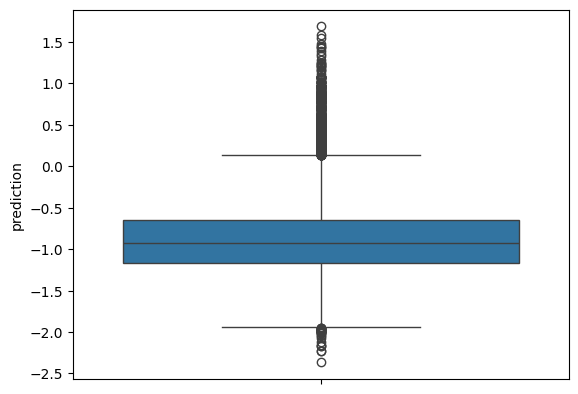

In [29]:
sns.boxplot(predictions_finetuned_esm['prediction'])

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
NUM_EPOCHS_FIRST_ROUND = 10

train_losses_round1 = []
train_spearman_round1 = []

print("Started Traininig.", flush = True)

for epoch in range(NUM_EPOCHS_FIRST_ROUND):
    model.train()
    total_train_loss = 0.0
    total_train_samples = 0
    train_predictions = []
    train_targets = []

    for batch_num, (sequences, protein_tensors, targets) in enumerate(train_loader, start=1):
        targets = targets.to(device)
        encoded_seq = base_model.tokenizer(sequences, return_tensors='pt', padding=True).input_ids.to(device)
        attention_mask = base_model.tokenizer(sequences, return_tensors='pt', padding=True).attention_mask.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=encoded_seq, attention_mask=attention_mask)

        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        batch_size = targets.size(0)
        total_train_loss += loss.item() * batch_size
        total_train_samples += batch_size
        
        train_predictions.append(outputs.detach().cpu().numpy())
        train_targets.append(targets.cpu().numpy())

    avg_train_loss = total_train_loss / total_train_samples
    train_predictions_flat = np.concatenate(train_predictions)
    train_targets_flat = np.concatenate(train_targets)
    train_spearman_corr, _ = spearmanr(train_targets_flat, train_predictions_flat)

    train_losses_round1.append(avg_train_loss)
    train_spearman_round1.append(train_spearman_corr)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_FIRST_ROUND}] "
          f"Train Loss: {avg_train_loss:.4f}, Train Spearman: {train_spearman_corr:.4f}", flush = True)

        # -------------------------
    # Test Set Evaluation
    # -------------------------
    sequences_list = []
    predictions_list = []
    measured_list = []

    model.eval()
    with torch.no_grad():
        for batch_num, (sequences, protein_tensors, targets) in enumerate(test_loader, start=1):
            targets = targets.to(device)
            encoded_seq = base_model.tokenizer(sequences, return_tensors='pt', padding=True).input_ids.to(device)
            attention_mask = base_model.tokenizer(sequences, return_tensors='pt', padding=True).attention_mask.to(device)

            outputs = model(input_ids=encoded_seq, attention_mask=attention_mask)

            # Process each sample in the batch:
            for i, sequence in enumerate(sequences):
                # If the protein object has an attribute (e.g., `sequence.sequence`), use it; otherwise, use the raw value.
                if hasattr(sequence, "sequence"):
                    sequences_list.append(sequence.sequence)
                else:
                    sequences_list.append(sequence)
                predictions_list.append(outputs[i].cpu().numpy().item())
                measured_list.append(targets[i].cpu().numpy().item())

    eval_spearman, _ = spearmanr(predictions_list, measured_list)
    eval_pearson, _ = pearsonr(predictions_list, measured_list)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_FIRST_ROUND}] "
          f"Train Loss: {avg_train_loss:.4f}, Eval Spearman: {eval_spearman:.4f} , Eval Pearson: {eval_pearson:.4f}", flush = True)

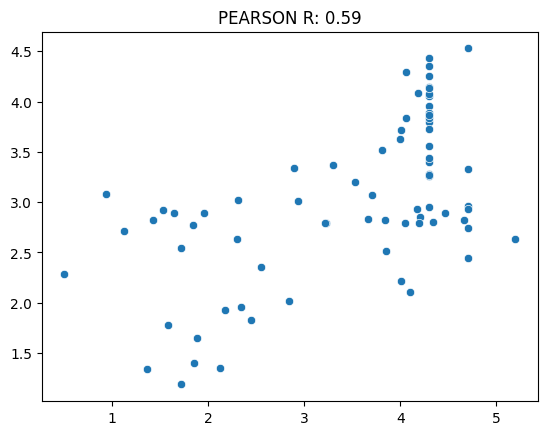

In [8]:
sns.scatterplot(x= measured_list, y =predictions_list)

pearson_r, _= pearsonr(predictions_list, measured_list)
plt.title(f"PEARSON R: {pearson_r:.2f}")

plt.show()

In [ ]:

# -------------------------
# Test Set Evaluation
# -------------------------
sequences_list = []
predictions_list = []
measured_list = []

model.eval()
with torch.no_grad():
    for batch_num, (sequences, protein_tensors, targets) in enumerate(test_loader, start=1):
        targets = targets.to(device)
        encoded_seq = base_model.tokenizer(sequences, return_tensors='pt', padding=True).input_ids.to(device)
        attention_mask = base_model.tokenizer(sequences, return_tensors='pt', padding=True).attention_mask.to(device)

        outputs = model(input_ids=encoded_seq, attention_mask=attention_mask)

        # Process each sample in the batch:
        for i, sequence in enumerate(sequences):
            # If the protein object has an attribute (e.g., `sequence.sequence`), use it; otherwise, use the raw value.
            if hasattr(sequence, "sequence"):
                sequences_list.append(sequence.sequence)
            else:
                sequences_list.append(sequence)
            predictions_list.append(outputs[i].cpu().numpy().item())
            measured_list.append(targets[i].cpu().numpy().item())

print("Done with predictions from test_loader.", flush=True)

predictions_finetuned_esm = pd.DataFrame({
    'sequence': sequences_list,
    'prediction': predictions_list,
    'measured': measured_list
})

Done with predictions from test_loader.


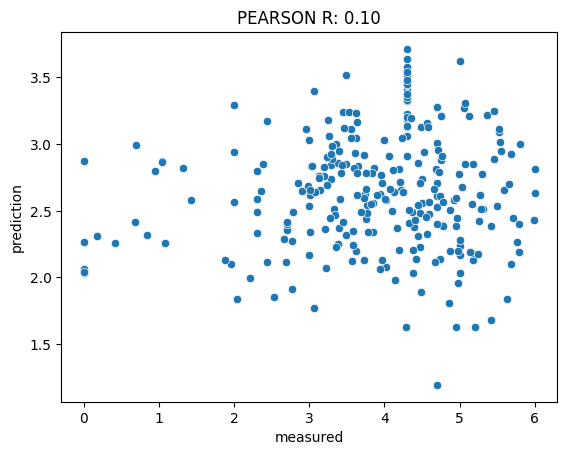

In [ ]:
sns.scatterplot(data = predictions_finetuned_esm, x= 'measured', y ='prediction')

pearson_r, _= pearsonr(predictions_finetuned_esm['measured'].values , predictions_finetuned_esm['prediction'].values)
plt.title(f"PEARSON R: {pearson_r:.2f}")

plt.show()

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
# import matplolib.pyplot as plt

Text(0.5, 1.0, 'ALL TRAIN DATA HISTOGRAM')

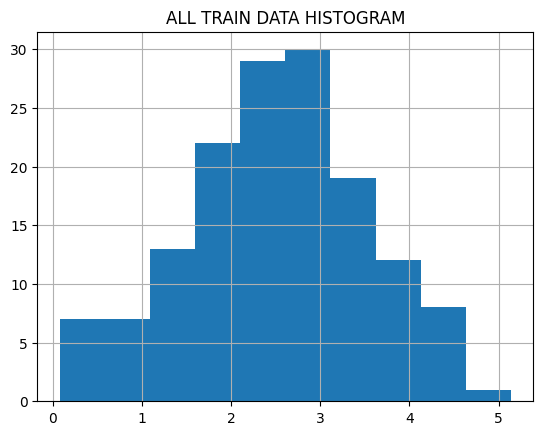

In [ ]:
train_data['label'].hist()
plt.title('ALL TRAIN DATA HISTOGRAM')

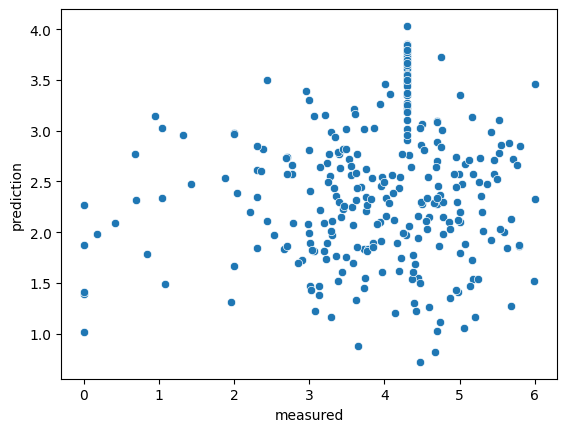

In [ ]:
sns.scatterplot(data = predictions_finetuned_esm, x= 'measured', y ='prediction')
plt.show()

In [1]:
################################################
# 6. Define a simple FASTA parser
################################################
def parse_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as f:
        header = None
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append((header, seq))
                    seq = ""
                header = line[1:]
            else:
                seq += line
        # Append the last sequence if present
        if seq:
            sequences.append((header, seq))
    return sequences


############################################
# 7. Load and filter the data
############################################
train_fasta = "/global/scratch/users/sergiomar10/jupyter_notebooks/hla_protein_sequences.fasta"
all_data = parse_fasta(train_fasta)

In [2]:
filtered_data = []
for header, sequence in all_data:
    if sequence[0] != 'M':
        continue
    if len(sequence) < 50:
        continue
    if 'X' in sequence:
        continue

    header = header.split('|')[1][:7].replace('*','').replace(':','')

    filtered_data.append((header))

In [13]:
import pandas as pd
pre_trained_models = pd.read_csv('../performances/ESMCBA_models.csv')

In [15]:
import itertools
import os
import glob

# Define paths
script_path = '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/ESMCBA/models/ESM_Supervised/ESMCBA_classifier.py'
sh_file_dir = '/global/scratch/users/sergiomar10/slurm_jobs/ESMCBA_CLASSIFIER/'
os.makedirs(sh_file_dir, exist_ok=True)

# Hyperparameter combinations
trials = [1, 3, 4]
encoding = ['HLA', 'epitope']
training_prop = [0.5, 0.95]
blocks_unfrozen = [20, 30]
last_block_lr = [1e-3, 1e-4]
classifier_lr = [1e-3, 1e-5, 1e-6]  # Renamed from regression_block_lr to classifier_lr # Example HLA list; replace with your actual list
HLAs = filtered_data

for trial_n, encode, train_prop, num_block, lr_base, lr_class, HLA in itertools.product(
    trials, encoding, training_prop, blocks_unfrozen, last_block_lr, classifier_lr, HLAs
):
    # Find pre-trained model path
    path_model = glob.glob(f'/global/scratch/users/sergiomar10/models/ESMC_Pretrain/HLAHLA{HLA}/*_{encode}_*.pt')

    if len(path_model) < 1:
        print(f"No pre-trained model found for HLA {HLA} with encoding {encode}. Skipping.")
        continue
    
    pre_trained_models_path = path_model[0]
    pretrain_filepath_name = pre_trained_models_path.split('/')[-1].replace('.pt', '')
    
    # Construct unique file name
    file_name = f'ESMCBA_{pretrain_filepath_name}_{train_prop}_{num_block}_{encode}_{lr_base}_{lr_class}_{trial_n}_{HLA}'
    sh_filename = f'{file_name}.sh'
    sh_filepath = os.path.join(sh_file_dir, sh_filename)
    
    # Construct the command to run the classifier script with the current parameters
    cmd = (
        f'python3 {script_path} '
        f'--name_of_model ESMCBA_{encode}_{train_prop}_{num_block}_{pretrain_filepath_name}_{lr_base}_{lr_class}_{trial_n}_{HLA} '
        f'--encoding {encode} '
        f'--file_path {pre_trained_models_path} '
        f'--train_size {train_prop} '
        f'--blocks_unfrozen {num_block} '
        f'--base_block_lr {lr_base} '
        f'--classifier_lr {lr_class} '  # Updated argument name
        f'--HLA {HLA}'
    )

    # Write the SLURM script
    with open(sh_filepath, 'w') as sh_file:
        sh_file.write('#!/bin/bash\n')
        sh_file.write('#SBATCH --account=co_nilah\n')
        sh_file.write('#SBATCH --partition=savio3_gpu\n')
        sh_file.write('#SBATCH --qos=savio_lowprio\n')
        sh_file.write('#SBATCH --cpus-per-task=4\n')
        sh_file.write('#SBATCH --gres=gpu:1\n')
        sh_file.write('#SBATCH --requeue\n')
        sh_file.write('#SBATCH --time=02:10:00\n')
        sh_file.write(f'#SBATCH --job-name={file_name}\n')
        sh_file.write(f'#SBATCH --output=/global/scratch/users/sergiomar10/logs/ESMCBA_CLASSIFIER/{file_name}_%j.out\n')
        sh_file.write(f'#SBATCH --error=/global/scratch/users/sergiomar10/logs/ESMCBA_CLASSIFIER/{file_name}_%j.err\n')
        sh_file.write('source /clusterfs/nilah/sergio/miniconda3/etc/profile.d/conda.sh\n')
        sh_file.write('\n')
        sh_file.write('conda activate ESM_cambrian\n')
        sh_file.write('\n')
        sh_file.write(cmd + '\n')
        
    # Make the shell script executable
    os.chmod(sh_filepath, 0o755)
    
    print(f'Created shell script: {sh_filename}')

Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.0001_0.001_AUG_1_HLAA0101_1_0.5_20_HLA_0.001_0.001_1_A0101.sh
No pre-trained model found for HLA A0201 with encoding HLA. Skipping.
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.0001_1e-05_AUG_3_HLAA0202_1_0.5_20_HLA_0.001_0.001_1_A0202.sh
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.001_1e-06_AUG_1_HLAA0203_2_0.5_20_HLA_0.001_0.001_1_A0203.sh
Created shell script: ESMCBA_ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0206_3_0.5_20_HLA_0.001_0.001_1_A0206.sh
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.0001_0.001_AUG_1_HLAA0301_1_0.5_20_HLA_0.001_0.001_1_A0301.sh
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_6_HLAA1101_2_0.5_20_HLA_0.001_0.001_1_A1101.sh
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.001_0.001_AUG_1_HLAA2301_1_0.5_20_HLA_0.001_0.001_1_A2301.sh
Created shell script: ESMCBA_ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA2402_1_0.5_20_HLA_0.001_0.001_1_A2402.sh
Created shell script: ESMCBA_ESMMASK_HLA_FT_

In [11]:
import itertools
import os
import glob

script_path = '/global/scratch/users/sergiomar10/py_files/ESM-C_BA_09022025.py'
sh_file_dir = '/global/scratch/users/sergiomar10/slurm_jobs/ESMCBA_02032025'
os.makedirs(sh_file_dir, exist_ok=True)

trials = [1, 2, 3, 4]
encoding = ['HLA', 'epitope']
training_prop = [0.5, 0.8, 0.95]
blocks_unfrozen = [20, 30]
last_block_lr = [1e-3, 1e-4]
regression_block_lr = [1e-3, 1e-5, 1e-6]
HLAs = filtered_data

for trial_n, encode, train_prop, num_block, lr_base, lr_reg, HLA  in itertools.product(trials, encoding, training_prop, blocks_unfrozen, last_block_lr, regression_block_lr, HLAs):

    path_model = glob.glob(f'/global/scratch/users/sergiomar10/models/ESMC_Pretrain/HLAHLA{HLA}/*_{encode}_*.pt')

    if len(path_model) < 1:
        continue
    
    pre_trained_models_path = path_model[0]
    pretrain_filepath_name =  pre_trained_models_path.split('/')[-1].replace('.pt','')
    
    file_name = f'ESMCBA_{pretrain_filepath_name}_{train_prop}_{num_block}_{encode}_{lr_base}_{lr_reg}_{trial_n}_{HLA}'

    sh_filename = f'{file_name}.sh'
    sh_filepath = os.path.join(sh_file_dir, sh_filename)
    
    # Construct the command to run the script with the current parameters
    cmd = f'python3 {script_path} --name_of_model ESMCBA_{encode}_{train_prop}_{num_block}_{pretrain_filepath_name}_{lr_base}_{lr_reg}__{trial_n}_{HLA} --encoding {encode} --file_path {pre_trained_models_path} --train_size {train_prop} --blocks_unfrozen {num_block} --base_block_lr {lr_base} --regression_block_lr {lr_reg} --HLA {HLA}'

    with open(sh_filepath, 'w') as sh_file:
        sh_file.write('#!/bin/bash\n')
        sh_file.write('#SBATCH --account=co_nilah\n')
        sh_file.write('#SBATCH --partition=savio3_gpu\n')
        sh_file.write('#SBATCH --qos=savio_lowprio\n')
        sh_file.write('#SBATCH --cpus-per-task=4\n')
        sh_file.write('#SBATCH --gres=gpu:1\n')
        sh_file.write('#SBATCH --requeue\n')
        sh_file.write('#SBATCH --time=02:10:00\n')
        sh_file.write(f'#SBATCH --job-name={file_name}\n')
        sh_file.write(f'#SBATCH --output=/global/scratch/users/sergiomar10/logs/ESMCBA_02032025/{file_name}_%j.out\n')
        sh_file.write(f'#SBATCH --error=/global/scratch/users/sergiomar10/logs/ESMCBA_02032025/{file_name}_%j.err\n')
        sh_file.write('source /clusterfs/nilah/sergio/miniconda3/etc/profile.d/conda.sh\n')
        sh_file.write('\n')
        sh_file.write('conda activate ESM_cambrian\n')
        sh_file.write('\n')

        sh_file.write(cmd + '\n')
        
    # Make the shell script executable
    os.chmod(sh_filepath, 0o755)
    
    print(f'Created shell script: {file_name}')
    # if 'HLA' == 

Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.0001_0.001_AUG_1_HLAA0101_1_0.5_20_HLA_0.001_0.001_1_A0101
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.0001_1e-05_AUG_3_HLAA0202_1_0.5_20_HLA_0.001_0.001_1_A0202
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.001_1e-06_AUG_1_HLAA0203_2_0.5_20_HLA_0.001_0.001_1_A0203
Created shell script: ESMCBA_ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0206_3_0.5_20_HLA_0.001_0.001_1_A0206
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.0001_0.001_AUG_1_HLAA0301_1_0.5_20_HLA_0.001_0.001_1_A0301
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_6_HLAA1101_2_0.5_20_HLA_0.001_0.001_1_A1101
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.001_0.001_AUG_1_HLAA2301_1_0.5_20_HLA_0.001_0.001_1_A2301
Created shell script: ESMCBA_ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA2402_1_0.5_20_HLA_0.001_0.001_1_A2402
Created shell script: ESMCBA_ESMMASK_HLA_FT_25_0.001_1e-05_AUG_1_HLAA2403_1_0.5_20_HLA_0.001_0.001_1_A2403
Created shell script: ESMCBA_ES

In [69]:
'_' + encode + '_' in path_model[0]

True